In [1]:
import torch
import time
import numpy as np
import subprocess
import yaml
from itertools import product
import random
import math
import matplotlib.pyplot as plt
import gc
import pandas as pd
import logging

In [2]:
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True)

In [3]:
if torch.cuda.is_available() == False:
    raise RuntimeError("Cuda is not available!")
else:
    logging.info("Cuda is available")
device = 'cuda'

2025-10-22 18:34:55,016 - INFO - Cuda is available


In [4]:
def get_power_limit():
    result = subprocess.run(["nvidia-smi", "--query-gpu=power.limit", "--format=csv"], capture_output=True, text=True)
    logging.debug(f"Result in get_power_limit():\n{result.stdout}")
    return float(result.stdout.split('\n')[1].split()[0])

def get_sm_clock():
    result = subprocess.run(["nvidia-smi", "--query-gpu=clocks.max.sm", "--format=csv"], capture_output=True, text=True)
    logging.debug(f"Result in get_sm_clock():\n{result.stdout}")
    return float(result.stdout.split('\n')[1].split()[0])    

In [5]:
with open("sm_cores.yaml", "r") as file:
    sm_cores = yaml.safe_load(file)
    logging.info("sm_cores.yaml loaded successfuly")

2025-10-22 18:34:55,048 - INFO - sm_cores.yaml loaded successfuly


In [6]:
props = torch.cuda.get_device_properties(0)

device_information = {
    "device_name": torch.cuda.get_device_name(0),
    "number_of_sm": props.multi_processor_count,
    "power_limit": {
        "value": get_power_limit(),
        "unit": "W"
    },
    "compute_capability": (props.major, props.minor),
    "cores_per_sm": sm_cores['cuda_cores_per_sm'][f"{props.major}.{props.minor}"],
    "sm_clock": {
        "value": get_sm_clock(),
        "unit": "MHz"
    },
    "memory": {
        "value": round(torch.cuda.mem_get_info()[1] / (1024**3), 2),
        "unit": "GiB"
    }
}
device_information["total_number_of_cores"] = device_information["number_of_sm"] * device_information["cores_per_sm"]
device_information["theoretical_flops"] = {
    "value": round((device_information["total_number_of_cores"] * device_information["sm_clock"]["value"] * 2 * 1e6) / 1e12, 2),
    "unit": "tflops",
    "precision": "float32"
}
logging.info(f"Device information:\n{device_information}")

2025-10-22 18:34:55,137 - DEBUG - Result in get_power_limit():
power.limit [W]
220.00 W

2025-10-22 18:34:55,183 - DEBUG - Result in get_sm_clock():
clocks.max.sm [MHz]
2160 MHz

2025-10-22 18:34:55,294 - INFO - Device information:
{'device_name': 'NVIDIA GeForce RTX 3070', 'number_of_sm': 46, 'power_limit': {'value': 220.0, 'unit': 'W'}, 'compute_capability': (8, 6), 'cores_per_sm': 128, 'sm_clock': {'value': 2160.0, 'unit': 'MHz'}, 'memory': {'value': 7.67, 'unit': 'GiB'}, 'total_number_of_cores': 5888, 'theoretical_flops': {'value': 25.44, 'unit': 'tflops', 'precision': 'float32'}}


### Settings

In [7]:
dtype = torch.float16
memory_overhead = 0.02

In [34]:
def benchmark_gemm(M, N, K, device, dtype, n_warmup, n_repeat):
    A = torch.rand(M, N, device = device, requires_grad=False, dtype = dtype)
    B = torch.rand(N, K, device = device, requires_grad=False, dtype = dtype)
    C = torch.rand(M, K, device = device, requires_grad=False, dtype = dtype)
    
    total_time = []
    flops = []
    start = torch.cuda.Event(enable_timing = True)
    end = torch.cuda.Event(enable_timing = True)
    
    for i in range(n_warmup):
        torch.mm(A, B, out=C)
        
    for i in range(n_repeat):    
        start.record()
        torch.mm(A, B, out=C)
        end.record()
        torch.cuda.synchronize()
        total_time.append(start.elapsed_time(end) / 1000) # measured in seconds
        
        n_ops = int(2 * M * N * K)
        flops.append(n_ops / total_time[i] / 1e12)

    del A
    del B
    del C
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    torch.cuda.synchronize()    

    result = {
        "M": int(M),
        "N": int(N),
        "K": int(K),
        "n_ops": int(2 * M * N * K),
        "time_elapsed": total_time,
        "flops": flops,
        "mean_flops": float(np.array(flops).mean()),
        "dtype": str(dtype)
    }

    return result

In [16]:
dim_size = [2 * 2**i for i in range(20)] + [3 * 2**i for i in range(20)]
all_dims = list(product(dim_size, (torch.float32, torch.float16)))
df = pd.DataFrame({
    "M": [x[0] for x in all_dims],
    "N": [x[0] for x in all_dims],
    "K": [x[0] for x in all_dims],
    "dtype": [x[1] for x in all_dims]
})
df["total_memory"] = (df["M"] * df["N"] + df["N"] * df["K"] + df["M"] * df["K"]) * df["dtype"].apply(lambda x: x.itemsize)
df = df.loc[df["total_memory"] < (device_information["memory"]["value"] * 1024**3 / (1 + memory_overhead))]

dtype_order = [torch.float16, torch.float32]
df["dtype"] = pd.Categorical(df["dtype"], categories = dtype_order, ordered=True)
df = df.sort_values(by=["dtype", "total_memory"]).reset_index(drop=True)

In [36]:
result = []
for index in range(len(df)):
    result.append(benchmark_gemm(
        M = df.iloc[index].loc["M"],
        N = df.iloc[index].loc["N"],
        K = df.iloc[index].loc["K"],
        device = device,
        dtype = df.iloc[index].loc["dtype"],
        n_warmup = 20,
        n_repeat = 25))
    print(f"N: {result[-1]["N"]} dtype: {result[-1]['dtype']} flops: {result[-1]['mean_flops']:.2f}")

N: 2 dtype: torch.float16 flops: 0.00
N: 3 dtype: torch.float16 flops: 0.00
N: 4 dtype: torch.float16 flops: 0.00
N: 6 dtype: torch.float16 flops: 0.00
N: 8 dtype: torch.float16 flops: 0.00
N: 12 dtype: torch.float16 flops: 0.00
N: 16 dtype: torch.float16 flops: 0.00
N: 24 dtype: torch.float16 flops: 0.00
N: 32 dtype: torch.float16 flops: 0.00
N: 48 dtype: torch.float16 flops: 0.01
N: 64 dtype: torch.float16 flops: 0.03
N: 96 dtype: torch.float16 flops: 0.08
N: 128 dtype: torch.float16 flops: 0.21
N: 192 dtype: torch.float16 flops: 0.70
N: 256 dtype: torch.float16 flops: 1.60
N: 384 dtype: torch.float16 flops: 5.64
N: 512 dtype: torch.float16 flops: 11.64
N: 768 dtype: torch.float16 flops: 20.99
N: 1024 dtype: torch.float16 flops: 23.36
N: 1536 dtype: torch.float16 flops: 29.17
N: 2048 dtype: torch.float16 flops: 36.46
N: 3072 dtype: torch.float16 flops: 38.97
N: 4096 dtype: torch.float16 flops: 37.96
N: 6144 dtype: torch.float16 flops: 44.98
N: 8192 dtype: torch.float16 flops: 46.16
N

In [38]:
with open("output_file.yaml", "w") as file:
    yaml.dump(result, file)

In [45]:
n_ops = []
flops = []
for x in result:
    n_ops.append(math.log2(x['N']))
    flops.append(float(x['mean_flops']))

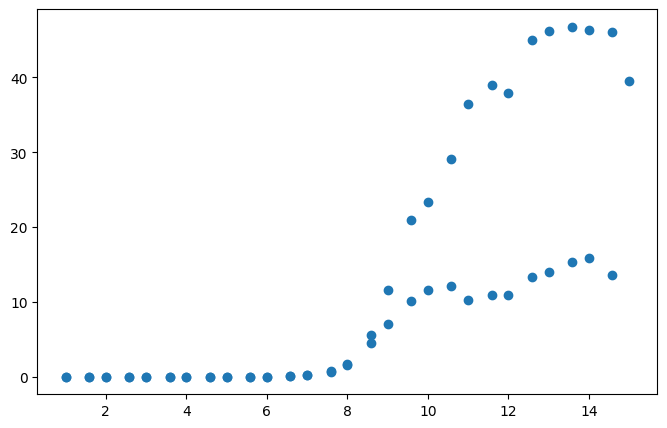

In [47]:
plt.figure(figsize=(8,5))
plt.plot(n_ops, flops, marker='o', linestyle='')
plt.show()